In [1]:
from pathlib import Path
import random

import os
import sys
import glob


import librosa
import librosa.display

import simplejpeg
import numpy as np

import torch
import torchvision as tv

import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Audio, display

# sys.path.append(os.path.abspath(f'{os.getcwd()}/..'))
sys.path.append(os.path.join(os.getcwd(), 'AudioCLIP-master'))

from model import AudioCLIP
from utils.transforms import ToTensor1D




Hyperparameters

In [2]:
import wandb

dialogue_number = 20
audio_length = 2000 # (ms)
LEARNING_RATE = 4e-4
NUM_EPOCHS = 30
DROP_OUT = 0.5

MODEL_FILENAME = 'AudioCLIP-Full-Training.pt'
# derived from ESResNeXt
SAMPLE_RATE = 44100
# derived from CLIP
IMAGE_SIZE = 224
IMAGE_MEAN = 0.48145466, 0.4578275, 0.40821073
IMAGE_STD = 0.26862954, 0.26130258, 0.27577711

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 1501985905 (1501985905-usc). Use `wandb login --relogin` to force relogin


True

Model Instantiation

In [3]:
aclp = AudioCLIP(pretrained=f'AudioCLIP-master/assets/{MODEL_FILENAME}')

Audio & Image Transforms

In [4]:
audio_transforms = ToTensor1D()

image_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(IMAGE_SIZE, interpolation=Image.BICUBIC),
    tv.transforms.CenterCrop(IMAGE_SIZE),
    tv.transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])

/home1/jinboliu/.conda/envs/csci566/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


Data Loading

In [5]:
import pandas as pd

# 读取CSV文件
df_train = pd.read_csv('data/MELD/MELD_kaggle/MELD-RAW/MELD_processed/train_sent_emo.csv')
df_test = pd.read_csv('data/MELD/MELD_kaggle/MELD-RAW/MELD_processed/test_sent_emo.csv')


In [6]:
from PIL import Image
import os

def data_loading(images_paths, audio_paths, df):
    
    images = []
    audio = []
    texts = []
    emotions = []
    sentiments = []
    
    for png_file in images_paths:
        img = Image.open(png_file)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = np.array(img)
        images.append(img)
    
    for train_audio_path in audio_paths:
        with torch.no_grad():
            track, _ = librosa.load(train_audio_path, sr=SAMPLE_RATE, dtype=np.float32)
            
            # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
            # thus, the actual time-frequency representation will be visualized
            spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)))
            spec = np.ascontiguousarray(spec.numpy()).view(np.complex64)
            pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()
        
            audio.append((track, pow_spec))
    
    for path in images_paths:
        # basename()获得filename.png，splitext()返回文件名和后缀filename, .png
        filename = os.path.splitext(os.path.basename(path))[0]
        dialogue_id = int(filename[3:filename.find('_')])
        utterance_id = int(filename[filename.find('utt')+3:])
    
        texts.append(df[(df['Dialogue_ID'] == dialogue_id) & (df['Utterance_ID'] == utterance_id)]['Utterance'].item())
        emotions.append(df[(df['Dialogue_ID'] == dialogue_id) & (df['Utterance_ID'] == utterance_id)]['Emotion'].item())
        sentiments.append(df[(df['Dialogue_ID'] == dialogue_id) & (df['Utterance_ID'] == utterance_id)]['Sentiment'].item())

    emotions = [0 if emotion == "neutral" else 1 if emotion == 'joy' else 2 if emotion == 'surprise' else 3 if emotion == 'anger' else 4 for emotion in emotions]
    sentiments = [0 if sentiment == "negative" else 1 if sentiment == 'neutral' else 2 for sentiment in sentiments]

    data = {
        "images": images,
        "audio": audio,
        "texts": texts,
        "emotions": emotions,
        "sentiments": sentiments,
    }
    return data
    

train_images_paths = glob.glob(f'data/MELD/MELD_kaggle/MELD-RAW/MELD_processed/demo_{dialogue_number}_{audio_length}ms/train/images/*.png')
train_audio_paths = glob.glob(f'data/MELD/MELD_kaggle/MELD-RAW/MELD_processed/demo_{dialogue_number}_{audio_length}ms/train/audio/*.wav')

test_images_paths = glob.glob(f'data/MELD/MELD_kaggle/MELD-RAW/MELD_processed/demo_{dialogue_number}_{audio_length}ms/test/images/*.png')
test_audio_paths = glob.glob(f'data/MELD/MELD_kaggle/MELD-RAW/MELD_processed/demo_{dialogue_number}_{audio_length}ms/test/audio/*.wav')

train_data = data_loading(train_images_paths, train_audio_paths, df_train)
test_data = data_loading(test_images_paths, test_audio_paths, df_test)

Show audio and images

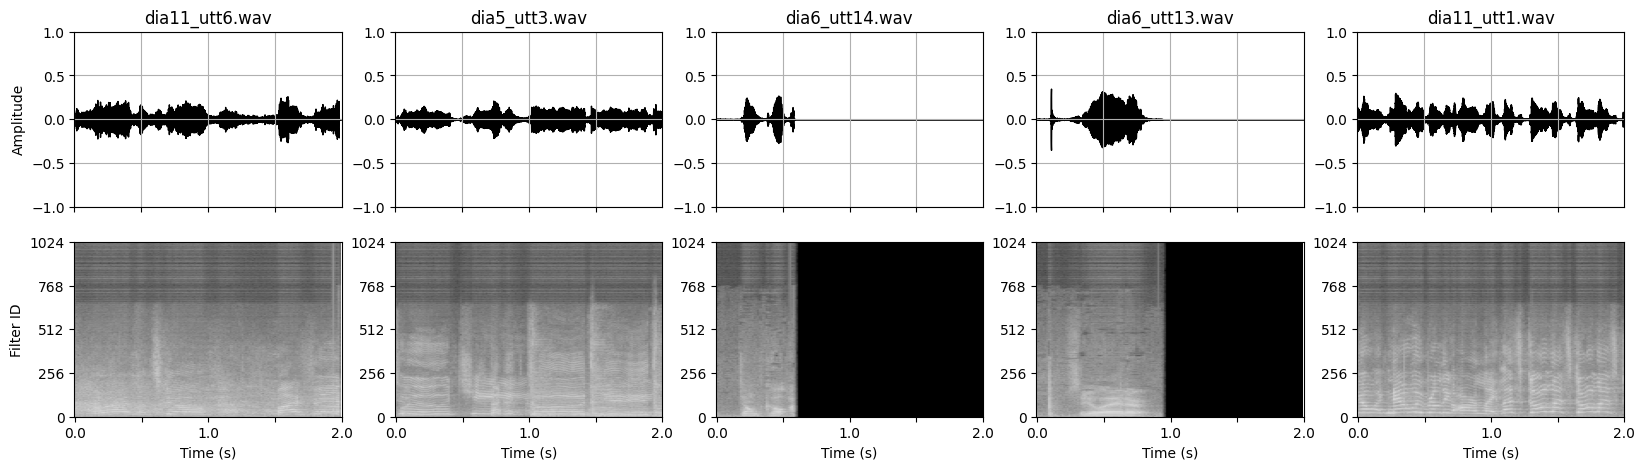

dia11_utt6.wav


dia5_utt3.wav


dia6_utt14.wav


dia6_utt13.wav


dia11_utt1.wav


In [7]:
fig, axes = plt.subplots(2, len(train_data['audio'][:5]), figsize=(20, 5), dpi=100)

audio = train_data['audio'][:5]
for idx in range(len(audio)):
    track, pow_spec = audio[idx]

    # draw the waveform
    librosa.display.waveplot(track, sr=SAMPLE_RATE, ax=axes[0, idx], color='k')
    # show the corresponding power spectrogram
    axes[1, idx].imshow(pow_spec, origin='lower', aspect='auto', cmap='gray', vmin=-180.0, vmax=20.0)

    # modify legend
    axes[0, idx].set_title(os.path.basename(train_audio_paths[idx]))
    axes[0, idx].set_xlabel('')
    axes[0, idx].set_xticklabels([])
    axes[0, idx].grid(True)
    axes[0, idx].set_ylim(bottom=-1, top=1)

    axes[1, idx].set_xlabel('Time (s)')
    axes[1, idx].set_xticks(np.linspace(0, pow_spec.shape[1], len(axes[0, idx].get_xticks())))
    axes[1, idx].set_xticklabels([f'{tick:.1f}' if tick == int(tick) else '' for tick in axes[0, idx].get_xticks()])
    axes[1, idx].set_yticks(np.linspace(0, pow_spec.shape[0] - 1, 5))

axes[0, 0].set_ylabel('Amplitude')
axes[1, 0].set_ylabel('Filter ID')

plt.show()
plt.close(fig)

for idx, path in enumerate(train_audio_paths[:5]):
    print(os.path.basename(path))
    display(Audio(audio[idx][0], rate=SAMPLE_RATE, embed=True))

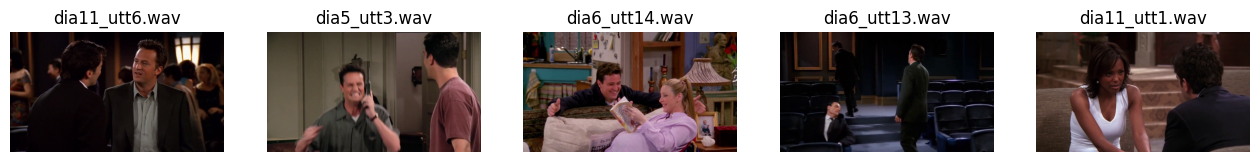

In [8]:
fig, axes = plt.subplots(1, len(train_data['images'][:5]), figsize=(16, 4), dpi=100)

for idx in range(len(train_data['images'][:5])):
    # re-arrange order to show the images column-wise
    axes[idx].imshow(train_data['images'][:5][idx])

    # modify legend
    axes[idx].axis('off')
    axes[idx].set_title(os.path.basename(train_audio_paths[idx]))

plt.show()
plt.close(fig)

Get embeddings by AudioCLIP

In [ ]:
from torchvision import datasets
import time
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

def process_audioclip(audio, images, texts): 
    
    
    with torch.no_grad():
        # AudioCLIP handles raw audio on input, so the input shape is [batch x channels x duration]
        tensors = [audio_transforms(track.reshape(1, -1)) for track, _ in audio]
        max_length = max(t.size(1) for t in tensors)
        padded_tensors = [F.pad(t, (0, max_length - t.size(1)), "constant", 0) for t in tensors]
        audio = torch.stack(padded_tensors)
        # standard channel-first shape [batch x channels x height x width]
        images = torch.stack([image_transforms(image) for image in images])
        # textual input is processed internally, so no need to transform it beforehand
        texts = [[text] for text in texts]


        # AudioCLIP's output: Tuple[Tuple[Features, Logits], Loss]
        # Features = Tuple[AudioFeatures, ImageFeatures, TextFeatures]
        # Logits = Tuple[AudioImageLogits, AudioTextLogits, ImageTextLogits]
        ((audio_features, _, _), _), _ = aclp(audio=audio)
        end_time = time.time()
        print(f"audio features completed: {end_time - start_time:.4f} seconds")
        
        ((_, image_features, _), _), _ = aclp(image=images)
        ((_, _, text_features), _), _ = aclp(text=texts)

        end_time = time.time()
        print(f"image and text features completed: {end_time - start_time:.4f} seconds")
        
        audio_features = audio_features / torch.linalg.norm(audio_features, dim=-1, keepdim=True)
        image_features = image_features / torch.linalg.norm(image_features, dim=-1, keepdim=True)
        text_features = text_features / torch.linalg.norm(text_features, dim=-1, keepdim=True)

    return torch.cat((audio_features, image_features, text_features), dim=1) #image_features#

start_time = time.time()

train_features_embedding = process_audioclip(train_data['audio'], train_data['images'], train_data['texts'])
test_features_embedding = process_audioclip(test_data['audio'], test_data['images'], test_data['texts'])

end_time = time.time()
print(f"Running time: {end_time - start_time:.4f} seconds")

audio features completed: 47.4305 seconds
image and text features completed: 124.6778 seconds
audio features completed: 144.9073 seconds
image and text features completed: 177.6400 seconds
Running time: 177.6413 seconds


Get dataloader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# 转换成DataLoader可接受类型
train_tensor_data = TensorDataset(train_features_embedding, torch.tensor(train_data['sentiments']))
test_tensor_data = TensorDataset(test_features_embedding, torch.tensor(test_data['sentiments']))

train_dataloader = DataLoader(dataset=train_tensor_data,
                              batch_size=16, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?
test_dataloader = DataLoader(dataset=test_tensor_data,
                              batch_size=16, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=False) # shuffle the data?



Create model

In [ ]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

class MLP1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_shape, out_features=output_shape)
        # self.layer_2 = nn.Linear(in_features=hidden_shape, out_features=output_shape)
        # self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.layer_1(x)
        return x

class MLP2(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_shape: int, DROP_OUT):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_shape, out_features=hidden_shape)
        self.layer_2 = nn.Linear(in_features=hidden_shape, out_features=output_shape)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROP_OUT)

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.dropout(x)
        x = self.layer_2(x)
        return x

Create train & test loop functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device
              ):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device
             ):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Creating a train() function

In [ ]:
# from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          device,
          wb_run,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
         ):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    #for epoch in tqdm(range(epochs)):
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device = device
                                          )
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device = device
                                       )

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        wb_run.log({
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc
        })
        
        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        

    # 6. Return the filled results at the end of the epochs
    return results

Train and Evaluate Model

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

run1 = wandb.init(
    # Set the project where this run will be logged
    project="main_MELD",
    name = f"MLP1_demo_{dialogue_number}_{audio_length}ms",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS,
        "drop_out_rate": DROP_OUT
    }
)

# Recreate an instance of MLP1
model_my = MLP1(input_shape=3072, output_shape=len(set(train_data['sentiments']))).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_my.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_my_results = train(model=model_my,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         optimizer=optimizer,
                         device = device,
                         wb_run = run1,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS)

run1.finish()

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

run2 = wandb.init(
    # Set the project where this run will be logged
    project="main_MELD",
    name = f"MLP2_demo_{dialogue_number}_{audio_length}ms",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS,
        "drop_out_rate": DROP_OUT
    }
)
# Recreate an instance of MLP2
model_my = MLP2(input_shape=3072, output_shape=len(set(train_data['sentiments'])), hidden_shape=500, DROP_OUT=DROP_OUT).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_my.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_my_results = train(model=model_my,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         optimizer=optimizer,
                         device = device,
                         wb_run = run2,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS)

run2.finish()

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")